<a href="https://colab.research.google.com/github/RiceD2KLab/Audubon_F21/blob/main/Audubon_Bird_Detection_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Houston Audubon Bird Detection Tutorial 
Authors: Krish Kabra, Alexander Xiong, Minxuan Luo, William Lu 

This Colab notebook contains tutorial code to perform bird detection using drone imagery based on the work done by Houston Audubon and students from the D2K capstone project course at Rice University. 

## Installation and setup for Colab

Run the next cells to setup Colab with the necessary requirements. We clone the Github repo with the developed code, and install dependencies, namely Detectron2. 

In [ ]:
# Import useful libraries
import os, sys, shutil, glob
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2
from skimage import io  
from datetime import datetime
from distutils.dir_util import copy_tree

In [ ]:
# This cell only excecutes if you're running on Colab. 
if 'google.colab' in sys.modules:
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone Audubon bird detection Github repo 
  !git clone https://github.com/RiceD2KLab/Audubon_F21.git 

  # Install dependencies 
  !pip install -qq pyyaml==5.1
  # This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
  !pip install -qq torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

  # Install detectron2 that matches the above pytorch version
  # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
  !pip install -qq detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
  # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

  !pip install -qq wandb

  # For AWS
  !pip install boto3
  # For confusion matrix
  !pip install prettytable

## Data exploration & wrangling

The following cells contain the data exploration and wrangling modules of the data science pipeline. 


### Load dataset from Google Drive 

The following cell unzips a folder stored on Google Drive ontop the Colab machine. You can modify this cell to load your drone images onto the Colab instance! 


In [ ]:
!mkdir -p './data/raw'
!gdown -q https://drive.google.com/uc?id=1zhB6_MLtvD0JCoyKYqhUx497WIvSYVUk
!unzip -q './1017_1.zip' -d './data/raw'
!gdown -q https://drive.google.com/uc?id=1clRsR5zg60FYjQ-crGx8CN88yPsUgVse
!unzip -q './1017_2.zip' -d './data/raw'
!gdown -q https://drive.google.com/uc?id=1fC4xAZJFoEccrgBhvjLMGpzLVXEcfHm6
!unzip -q './annotation_1017.zip' -d './data/raw'

### Data exploration 

The following cells generate some metrics and plots to help understand the loaded dataset. 


 Bird Species Distribution
Mixed Tern Adult                   8641
Laughing Gull Adult                3168
Brown Pelican Adult                 496
Mixed Tern Flying                   156
Other Bird                           95
Laughing Gull Flying                 86
Brown Pelican - Wings Spread         29
Trash/Debris                         23
Great Egret/White Morph Adult        23
Brown Pelican Juvenile               20
Brown Pelican In Flight              17
Brown Pelican Wings Spread           14
Tri-Colored Heron Adult              11
Brown Pelican Chick                   6
Roseate Spoonbill Adult               1
Black Crowned Night Heron Adult       1
Name: class_name, dtype: int64




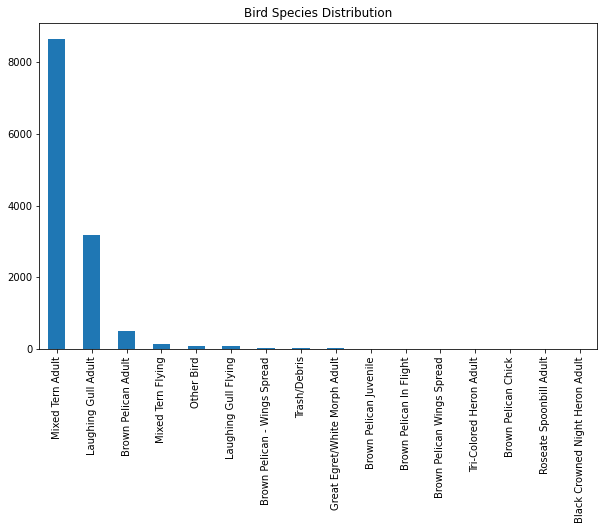

In [ ]:
# This cell plots the distribution of bird species contained in the entire dataset
data_dir = './data/raw' # data directory folder 

# Load CSV files 
target_data = []
for f in glob.glob(os.path.join(data_dir,'*.bbx')): 
  target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
target_data = pd.concat(target_data, axis=0, ignore_index=True)

# Create table and bar plot of bird species  
print('\n Bird Species Distribution')
print(target_data["class_name"].value_counts())
print('\n')

ax = target_data["class_name"].value_counts().plot.bar(x="Bird Species", y="Frequency",figsize=(10,6))  
ax.set_title('Bird Species Distribution')
plt.show()

In [ ]:
# Show an example image with corresponding bounding boxes 
from PIL import Image 
from Audubon_F21.utils import plotting
from Audubon_F21.utils.cropping import csv_to_dict 

annot_dict = csv_to_dict(csv_path = './data/raw/DJI_20210520122307_0033.bbx', annot_file_ext='bbx')
annotation_lst = [list(x.values()) for x in annot_dict['bbox']]

image_file = './data/raw/DJI_20210520122307_0033.JPG'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
print("Raw image with bounding boxes:")
plotting.plot_img_bbx(image, annotation_lst)

### Tiling 

In order to prepare the dataset to be used for training in our deep learning models, we must tile the large 8192 × 5460 raw drone images into smaller sizes. The size of generated images can be specified by setting parameters and is default to be 640 × 640.

The following cells tiles the original dataset images and corresponding annotations in annotation files. 

In [ ]:
from Audubon_F21.utils.cropping import crop_dataset

# data_dir is the path that contains both images and annotations (image: jpg; annotation: csv or bbx)
data_dir = './data/raw' # data directory folder 
# output dir is the path where you want to output new files. Please use the folder you defined above.
output_dir = './data/tiled'

crop_dataset(data_dir, output_dir, annot_file_ext = 'bbx', crop_height = 640, crop_width = 640)

### Split dataset into training, validation, and test 


In [ ]:
 from Audubon_F21.utils.cropping import train_val_test_split

# create a new output folder for train, val, test dataset
# create three folders under the new output folder, with name 'train', 'val', 'test'
!mkdir -p /content/data/split
!mkdir -p /content/data/split/train
!mkdir -p /content/data/split/val
!mkdir -p /content/data/split/test

# specify the folder directory where you have the tiled images (output_dir of the crop_dataset() function)
file_dir = '/content/data/tiled'
# output_dir is the new output folder you created in the cell above
output_dir = '/content/data/split'
# train is a percentage, the fraction of files for training
train_frac = 0.8
# val is a percentage, the fraction of files for validation
val_frac = 0.1
# the fraction for test is default to be 1-train-val
train_val_test_split(file_dir, output_dir, train_frac=train_frac, val_frac=val_frac)

In [ ]:
# Distribution of bird species for train, val, and test sets
# data directory folders 
data_dir = 'data/split'
dirs = [d for d in os.listdir(data_dir)]

# Load CSV files 
for d in dirs: 
  target_data = []
  for f in glob.glob(os.path.join(data_dir,d,'*.csv')): 
    target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
  target_data = pd.concat(target_data, axis=0, ignore_index=True)

  # Visualize dataset 
  print(f'\n {d} - Bird Species Distribution')
  print(target_data["class_name"].value_counts())
  print('\n')

## Modeling 

The primary models used to detect birds within the drone images are convolutional neural network (CNN) based object detectors. To implement these models, we utilize [Detectron2](https://github.com/facebookresearch/detectron2), Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. 



### Setup dataloaders 

The following cell registers the training, validation, and testing datasets with Detectron2's dataset catalogs. Note that we register both a version that utilizes both a singular "bird-only" label and the bird species labels. 


In [ ]:
from Audubon_F21.utils.dataloader import register_datasets

data_dir = './data/split'
img_ext='.JPEG'
dirs = [os.path.join(data_dir,d) for d in os.listdir(data_dir)]

# Bird species used by object detector. Species contained in dataset that are 
# not contained in this list will be categorized as an "Unknown Bird"
BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]

# Bounding box colors for bird species (used when plotting images)
BIRD_SPECIES_COLORS = [(255,0,0), (255,153,51), (0, 255, 0), 
                       (0,0,255), (255, 51, 255)]

register_datasets(dirs,img_ext,BIRD_SPECIES,bird_species_colors=BIRD_SPECIES_COLORS)

### Training 

The following cells train a RetinaNet and Faster R-CNN model with a ResNet-50 FPN backbone. The model weights are initialized from a model pretrained on the MS COCO dataset. The training loop is based on Detectron2's Default Trainer.  Hyperparameters can be tweaked! 

#### Bird-only model

The bird-only model simplies localizes all birds and does not distiguish bird species. We utilize RetinaNet for faster performance rather than accuracy. 

In [ ]:
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2 import model_zoo
from Audubon_F21.utils.trainer import Trainer

# setup training logger 
setup_logger()

model_name = "retinanet_R_50_FPN_1x"

# Create detectron2 config 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# Get pretrained model from MS COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_only_train",)
cfg.DATASETS.TEST = ("birds_only_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 1e-3 # pick a good LR
cfg.SOLVER.GAMMA = 0.1 # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#### Bird species 

The bird species model both localizes and classifies bird species. We registered the species to be classifed in the above dataloader (see BIRD_SPECIES list). We utilize Faster R-CNN for better performance. 

In [ ]:
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2 import model_zoo
from Audubon_F21.utils.trainer import Trainer

# setup training logger 
setup_logger()

model_name = "faster_rcnn_R_50_FPN_1x"

# Create detectron2 config 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# Get pretrained model from MS COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_species_train",)
cfg.DATASETS.TEST = ("birds_species_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 1e-3 # pick a good LR
cfg.SOLVER.GAMMA = 0.1 # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES)
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### Evaluation

The following cell outputs various evaluation metrics, plots, and images. Please read more about the [COCO evaluation metrics](https://cocodataset.org/#detection-eval) to understand how the AP metrics are calculated. 

#### Bird-only

In [ ]:
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import plot_precision_recall

cfg.MODEL.WEIGHTS = "./output/bird_only_retinanet_R_50_FPN_1x/model_final.pth" # path to the model we just trained
predictor = DefaultPredictor(cfg)

print('validation inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_only_val")
plot_precision_recall(val_precisions, val_max_recalls, ["Bird"])

print('test inference:')
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_only_test")
plot_precision_recall(test_precisions, test_max_recalls, ["Bird"])

# Plot examples of detections on validation and testing tiled images 
for d in ["val", "test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_only_{d}")
    print(f'\n {d} examples:')
    for k in random.sample(dataset_dicts, 2):
        im = cv2.imread(k["file_name"])
        outputs = predictor(im)
        outputs = outputs["instances"].to("cpu")
        outputs = outputs[outputs.scores > 0.5]
        v = Visualizer(im[:, :, ::-1],
                        metadata=MetadataCatalog.get(f"birds_only_{d}"),
                        scale=0.5)
        out = v.draw_instance_predictions(outputs)
        cv2.imshow(f'{d} prediction {i}',out.get_image()[:, :, ::-1])

#### Bird species 

In [ ]:
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import plot_precision_recall

cfg.MODEL.WEIGHTS = "./output/multibirds_faster_rcnn_R_50_FPN_1x/model_final.pth" # path to the model we just trained
predictor = DefaultPredictor(cfg)

print('validation inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_val")
plot_precision_recall(val_precisions, val_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

print('test inference:')
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_test")
plot_precision_recall(test_precisions, test_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

# Plot examples of detections on validation and testing tiled images 
for d in ["val", "test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_species_{d}")
    print(f'\n {d} examples:')
    for k in random.sample(dataset_dicts, 2):
        im = cv2.imread(k["file_name"])
        outputs = predictor(im)
        outputs = outputs["instances"].to("cpu")
        outputs = outputs[outputs.scores > 0.5]
        v = Visualizer(im[:, :, ::-1],
                        metadata=MetadataCatalog.get(f"birds_species_{d}"),
                        scale=0.5,
                        instance_mode=ColorMode.SEGMENTATION)
        out = v.draw_instance_predictions(outputs)
        cv2.imshow(f'{d} prediction {i}',out.get_image()[:, :, ::-1])

## Running trained model on dataset

The following cells run a pretrained model on a dataset containing only raw images. It generates an output csv file containing the predicted bounding boxes after non-maximal suppression. 


### Tiling

The tiling step in the detection pipeline is done using a sliding window. The sub-images are deliberately generated to have a significant proportion of overlapping with adjacent sub-images. The level of overlapping can be specified by setting a parameter. The reason why we want to have the overlapping is because we can ensure that there is at least one complete version of each bird in one of the sub-images. We then try to eliminate overlapping predicted bounding boxes for the same bird by using non-maximum suppression.



In [ ]:
from Audubon_F21.utils.cropping import crop_dataset_img_only

# create folder to contain tiled images
!rm -rf './data/crop'
!mkdir -p './data/crop'

# perform tiling on images 
data_dir = './data/raw' # data directory folder 
output_dir = './data/crop'
img_ext = '.JPG'
CROP_WIDTH = 640 
CROP_HEIGHT = 640
SLIDING_SIZE = 400 
crop_dataset_img_only(data_dir, img_ext, output_dir, crop_height=CROP_HEIGHT, crop_width=CROP_WIDTH, sliding_size=SLIDING_SIZE)

### Run pipeline

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import evaluate_full_pipeline

# create list of tiled images to be run predictor on 
eval_file_lst = []
eval_file_lst = eval_file_lst + glob.glob('./data/crop/*.JPEG')

# Create detectron2 config and predictor 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# download model weights
!gdown -q https://drive.google.com/uc?id=1-f_INg5D0yG7AJUkuSJUcIl6BSaf-smR 
# load model weights 
cfg.MODEL.WEIGHTS = "./model_final.pth"

BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]
SPECIES_MAP = {0: 'Brown Pelican', 1: 'Laughing Gull', 2: 'Mixed Tern', 3: 'Great Blue Heron',
               4: 'Great Egret/White Morph', 5: 'Other/Unknown'}

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES) 

# Create default predictor to run inference 
predictor = DefaultPredictor(cfg)
RAW_IMG_WIDTH = 8192
RAW_IMG_HEIGHT = 5460

# Run evaluation 
output_df = evaluate_full_pipeline(eval_file_lst, predictor, SPECIES_MAP, RAW_IMG_WIDTH, RAW_IMG_HEIGHT,
                           CROP_WIDTH, CROP_HEIGHT, SLIDING_SIZE)

### Download annotations as CSV file 


In [ ]:
from google.colab import files
output_df.to_csv('output.csv')
files.download('output.csv') 